In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from util import *
from STMatrix import STMatrix
import cPickle as pickle
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(20,10))
%load_ext autoreload
%autoreload 2
import math
import h5py
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import LSTM, Input, Embedding, add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

# 道路属性表

In [ ]:
adj = pd.read_csv("data/gy_contest_link_top.txt", delimiter=';', dtype={'in_links': np.str, 'out_links': str})
adj = adj.fillna('')

info = pd.read_csv("data/gy_contest_link_info.txt", delimiter=';')

info.head()

# deepwalk embedding

In [ ]:
link_embeddings = pickle.load(file('link_embeddings.plk', 'rb'))

# 读取hdf5

In [ ]:
f = h5py.File('travel_time_second.hdf5', 'r')

In [ ]:
# stage = 'sample'
stage = 'real'

# LSTM

In [ ]:
minutes_per_slot = 2

In [ ]:
if stage == 'sample':
    links = np.random.choice(f.keys(), 1)
    links
else:
    links = f.keys()

In [ ]:
link2idx = dict(zip(links, range(len(links))))

In [ ]:
link2idx

## 定义向前记忆和向后预测步长

In [ ]:
g_look_back = 60
g_predict_forward = range(1, 15)
slide = 3
hypername = '{}_back{}_forward{}_slide{}'.format(
    stage, g_look_back, len(g_predict_forward), slide)

In [ ]:
denoised = False

## 构造训练集

In [ ]:
fname = create_target_set('train', links, f, hypername, info, link2idx, link_embeddings, 
                     g_look_back, g_predict_forward, slide, 
                    pd.date_range(datetime(2017,3,1), datetime(2017,5,30), freq='1d'),False, denoised)
trainX, trainY, trainIdx, trainTimestamp, trainForward, trainEmbedding = read_cache(fname)

In [ ]:
trainX.shape, trainY.shape, trainIdx.shape, trainEmbedding.shape, trainForward.shape

## 定义模型

In [ ]:
feature_selected = [0, 2, 3]

In [ ]:
model = build_model(trainX[:2, :,feature_selected], links)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='lstm.png', show_shapes=True)
from IPython.display import Image, FileLink
FileLink('lstm.png')

In [ ]:
batch_size = 30
early_stopping = EarlyStopping(monitor='mean_absolute_error', patience=2, mode='min')
model_checkpoint = ModelCheckpoint(
        'MODEL/'+hypername+'_best.h5', monitor='mean_absolute_error', verbose=0, save_best_only=True, mode='min')
tensorboard = TensorBoard()
model.reset_states()
# , trainEmbedding, trainForward

# CV

## 构造验证集

In [ ]:
cv_fname = create_target_set('cv', links, f, hypername, info, link2idx, link_embeddings, 
                     g_look_back, range(1, 31), slide, 
                    pd.date_range(datetime(2017,5,25), datetime(2017,5,30), freq='1d'),False, denoised)

In [ ]:
cvX, cvY, cvIdx, cvTimestamp, cvForward, cvEmbeddings = read_cache(cv_fname)

In [194]:
cvX.shape, cvY.shape

((90700, 60, 4), (90700, 1))

## 训练

In [ ]:
#  trainEmbedding, trainForward / 60.0
model.lr = 1e-4
model.fit([trainX[:, :, feature_selected], trainIdx, trainEmbedding], trainY, epochs=3, 
          batch_size=batch_size, verbose=1, shuffle=True, 
          validation_data=[[cvX[:, :, feature_selected], cvIdx, cvEmbeddings], cvY],
          callbacks=[early_stopping])

In [195]:
cvPredict = model.predict([cvX[:, :, feature_selected], cvIdx, cvEmbeddings]) #, cvEmbeddings, cvForward
# cv_mape = evaluate(cvPredict, cvY, cvIdx, cvTimestamp, cvForward)
cv_result = pd.DataFrame((np.hstack((cvPredict, cvY, 
                                         np.array(cvTimestamp).reshape(-1, 1), 
                                         np.array(cvForward).reshape(-1, 1),
                                        np.array(cvIdx).reshape(-1, 1)))), 
                 columns=['predict', 'real', 'time', 'forward', 'link'])
cv_result['predict'] = cv_result.predict.astype(np.float32)
cv_result['real'] = cv_result.real.astype(np.float32)
# cv_nearest = cv_result.groupby(['link', 'time']).apply(nearest)
cv_nearest = cv_result
predict = cv_nearest['predict'].values
real = cv_nearest['real'].values
cv_mape = mape(predict[real!=0], real[real!=0])
print 'cv mape: {}'.format(cv_mape)
# return cv_mape
model_name = 'MODEL/{}_cv{}.h5'.format(hypername, cv_mape)
model.save(model_name)
cv_mape

cv mape: 1.1029599905


1.10296

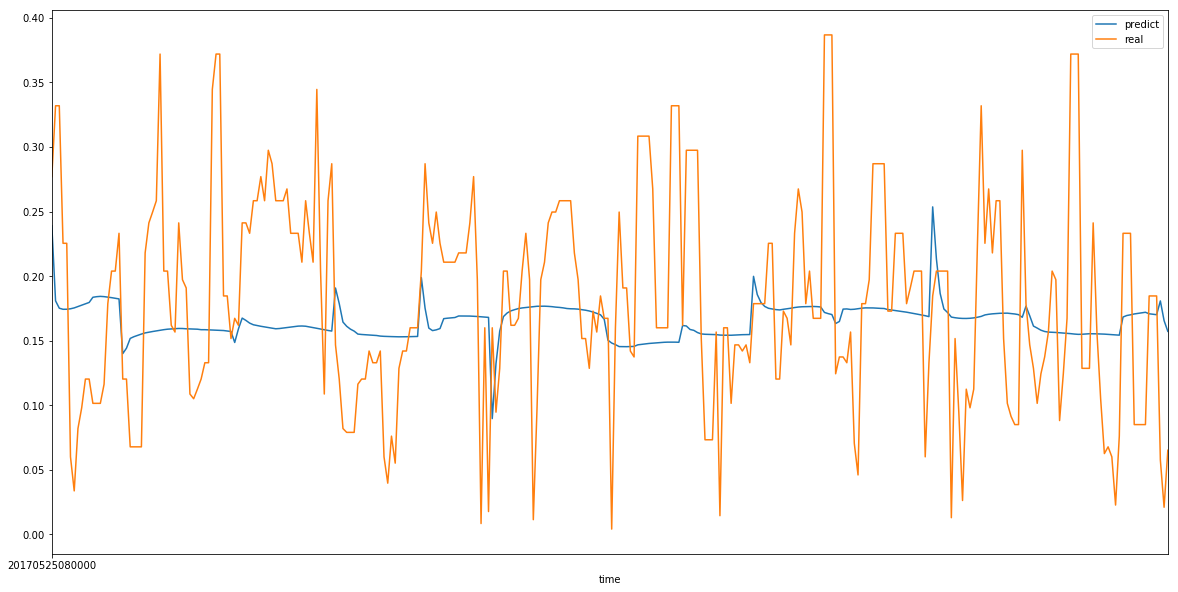

In [196]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,)
# pd.DataFrame(all_predict, index=all_time).resample('20min').mean().plot(label='predict', ax=ax)
# pd.DataFrame(all_Y, index=all_time).resample('20min').mean().plot(ax=ax)
# length = 200
# ax.plot(predict[:length], label="predict")
# ax.plot(real[:length], label="true")
ticks = [i * real.shape[0] / 10 for i in range(10)]
ax.set_xticks(ticks)
# ax.set_xticklabels([cvTimestamp[t] for t in ticks])
# plt.legend(loc='best')
# cv_nearest.plot(x=['predict'], y='time')
cv_nearest.head(300).plot(y=['predict', 'real'], x='time', ax=ax)

In [ ]:
denoised_data = np.reshape(denoise(train[('201605230600'):('201605230900')].travel_time.values, 'db3', 4, 1, 4), (-1, 1))
plt.plot(denoised_data, label='denoised')
plt.plot(train[('201605210600'):('201605210900')].travel_time.values, label='raw')
plt.legend(loc='best')

# Test

In [ ]:
for link in links:
    print link, f[link]['test']['time'].shape

In [ ]:
from keras.models import load_model
model = load_model('MODEL/forward10.h5')

In [ ]:
plot_model(model, to_file='best.png', show_shapes=True)
from IPython.display import Image, FileLink
Image('best.png')

In [ ]:
f[link]['test']['data'].value

In [197]:
all_predict = []
all_Y = []
all_time = []
all_test_forwards = []
all_links = []

for link in links:
    test_ds, test_ts = f[link]['test']['data'].value, f[link]['test']['time'].value
    length = info[info.link_ID==link]['length'].values[0]
    scaler = MinMaxScaler(feature_range=(0,1))
    test_ds[:, 0] = scaler.fit_transform((length / test_ds[:, 0]).reshape(-1, 1)).reshape(-1)
#     test_ds = test_ds[:, [0, 2]]
    for day in range(1, 31):
        predict_window_start = datetime(2017, 6, day, 8, 0)
        predict_window_end = predict_window_start + timedelta(minutes=59)

        
    #     train_window_start = datetime(2016, 5, day, hour, 0) - timedelta(hours=2)
    #     train_window_end = train_window_start + timedelta(hours=1, minutes=59)

        testX, testY, test_forwards, testYTime = create_dataset(length, test_ds, 
                                                              test_ts, 
                                                              predict_window_start, 
                                                              predict_window_end, 
                                                              1,                         
                                                              minutes_per_slot, 
                                                              g_look_back, 
                                                              range(1, 31),True)
        
        testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))
        testIdx = np.ones((testX.shape[0], 1)) * link2idx[link]
        testEmbeddings = np.array(link_embeddings[link]) * np.ones((testX.shape[0], 1))
#         testPredict = model.predict([testX[:, :, feature_selected], testIdx, testEmbeddings, np.array(test_forwards) / 60.0])
        testPredict = model.predict([testX[:, :, feature_selected], testIdx, testEmbeddings])
        testPredict = scaler.inverse_transform(testPredict)
        testPredict = length / testPredict
        all_predict.append(testPredict)
    #         all_time = cvYTime
        all_test_forwards += test_forwards
        all_time = all_time + list(np.reshape(testYTime, -1))
        all_links += [link] * len(testX)
all_predict = np.vstack(all_predict)
# print "cv MAPE: %f" % (mape(all_predict, all_Y))

In [198]:
len(all_time), all_predict.shape, np.array(all_test_forwards).reshape(-1, 1).shape

(118800, (118800, 1), (118800, 1))

In [199]:
test_result = pd.DataFrame((np.hstack((all_predict, np.array(all_time).reshape(-1, 1),
                                      np.array(all_test_forwards).reshape(-1, 1),
                                      np.array(all_links).reshape(-1, 1)))), 
             columns=['predict', 'time', 'forward', 'link'])
# test_result.index=test_result.time
test_result['predict'] = test_result.predict.astype(np.float32)

In [200]:
test_nearest = test_result.groupby(['link', 'time']).apply(nearest)

In [201]:
submission_name = "credo_%s.txt" % datetime.now().strftime('%Y%m%d')
write_submission(test_nearest, file(submission_name, 'w'))

In [202]:
check_submission(submission_name, links)

checking link: 3377906280028510514
link: 3377906280028510514 is complete
checking link: 3377906280395510514
link: 3377906280395510514 is complete
checking link: 3377906281518510514
link: 3377906281518510514 is complete
checking link: 3377906281774510514
link: 3377906281774510514 is complete
checking link: 3377906282328510514
link: 3377906282328510514 is complete
checking link: 3377906282418510514
link: 3377906282418510514 is complete
checking link: 3377906283328510514
link: 3377906283328510514 is complete
checking link: 3377906284028510514
link: 3377906284028510514 is complete
checking link: 3377906284395510514
link: 3377906284395510514 is complete
checking link: 3377906285434510514
link: 3377906285434510514 is complete
checking link: 3377906285934510514
link: 3377906285934510514 is complete
checking link: 3377906286918510514
link: 3377906286918510514 is complete
checking link: 3377906287674510514
link: 3377906287674510514 is complete
checking link: 3377906287886510514
link: 3377906287

# 其他

In [ ]:
stmatrix = STMatrix(f['9377906285566510514']['train']['data'].value, 
                    f['9377906285566510514']['train']['time'].value, 
                    T=720, CheckComplete=False, start=1)

In [ ]:
stmatrix.create_dataset(forward=1, len_closeness=3, 
                        len_trend=0, TrendInterval=7, len_period=0, PeriodInterval=1, slide=10)

In [ ]:
XC, XP, XT, Y, timestamps_Y = stmatrix.create_cv_dataset(datetime(2016,6,3,8), datetime(2016,6,3,9), forward=10, len_closeness=3, len_trend=0, TrendInterval=7, len_period=0, PeriodInterval=1, test=False)

In [ ]:
check_submission('credo_20170802.txt', sample_links)
# result = pd.read_csv('credo_20170802.txt', delimiter='#', names=['link', 'date', 'period', 'time'], index_col=["link", "period"])

In [ ]:
sample_links = np.random.choice(f.keys(), 20, replace=False)
# sample_links=f.keys()

In [ ]:
data = pd.DataFrame(np.vstack([f[link]['train']['data'].value[:, 0] for link in sample_links]).reshape(-1, len(sample_links)), columns=sample_links)

In [ ]:
import numpy
correlations = data.corr()  #计算变量之间的相关系数矩阵
# plot correlation matrix
fig = plt.figure() #调用figure创建一个绘图对象
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, cmap='Blues', vmin=-1, vmax=1)  #绘制热力图，从-1到1
fig.colorbar(cax)  #将matshow生成热力图设置为颜色渐变条
ticks = numpy.arange(len(sample_links)) #生成0-9，步长为1
ax.set_xticks(ticks)  #生成刻度
ax.set_yticks(ticks)
ax.set_xticklabels(sample_links) #生成x轴标签
ax.set_yticklabels(sample_links)
plt.show()

In [ ]:
correlations

In [ ]:
adj[adj.link_ID=='4377906287663800514']

In [ ]:
adj[adj.link_ID=='4377906287169500514']

In [ ]:
adj